## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  
8) модель с 50 любыми рекуррентными слоями


Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
from tensorflow.keras import backend as K
from random import choice
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens


def get_model(layer):
    dense = tf.keras.layers.Dense(N_LEN, activation='relu')(layer)
    outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
    return model


In [ ]:
data = pd.read_csv('lenta_40k.csv')

In [ ]:
processed_texts = []
vocab = Counter()

for text in data.text:
    processed_text = preprocess(text)
    vocab.update(processed_text)
    processed_texts.append(processed_text)

In [ ]:
word2id = {'PAD': 0, 'UNK': 1}

for word in vocab:
    word2id[word] = len(word2id)
id2word = {i: word for word, i in word2id.items()}

X = []
for text in processed_texts:
    ids = [word2id.get(token, 1) for token in text]
    X.append(ids)
    
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {l: i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [20]:
N_LEN = 64

models = []

1) модель с 1 GRU слоем;

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(N_LEN, return_sequences=False)(embeddings)

models.append(get_model(rnn))

2) модель с 1 LSTM слоем


In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(N_LEN, return_sequences=False)(embeddings)

models.append(get_model(rnn))


3) модель с 1 GRU и 1 LSTM слоем


In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(N_LEN, return_sequences=False)(lstm_1)

models.append(get_model(lstm_2))

4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = tf.keras.layers.LSTM(N_LEN, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(N_LEN, return_sequences=True))(bigru)
lstm_2 = tf.keras.layers.LSTM(N_LEN, return_sequences=False)(lstm_1)

models.append(get_model(lstm_2))

5) модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(N_LEN, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(N_LEN, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(N_LEN, return_sequences=False)(lstm_2)

models.append(get_model(lstm_3))

6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bilstm_forward =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LEN, return_sequences=False))(embeddings)
bigru_backward =  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(N_LEN, return_sequences=False, go_backwards=True))(embeddings)

hidden = tf.keras.layers.concatenate([bilstm_forward, bigru_backward])

models.append(get_model(hidden))

7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(N_LEN, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(lstm_1)
bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LEN, return_sequences=True))(gru_1)
bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(N_LEN, return_sequences=True))(bigru_1)
gru_2 = tf.keras.layers.GRU(N_LEN, return_sequences=True)(bilstm_1)
lstm_2 = tf.keras.layers.LSTM(N_LEN, return_sequences=False)(gru_2)

models.append(get_model(lstm_2))

8) модель с 50 любыми рекуррентными слоями

In [ ]:
N_LEN_SMALL = N_LEN // 2

rnn_layer = choice([tf.keras.layers.LSTM(N_LEN_SMALL, return_sequences=True)(embeddings),
                    tf.keras.layers.GRU(N_LEN_SMALL, return_sequences=True)(embeddings)])
for _ in range(49):
    rnn_layer = choice([tf.keras.layers.LSTM(N_LEN_SMALL, return_sequences=True)(rnn_layer),
                        tf.keras.layers.GRU(N_LEN_SMALL, return_sequences=True)(rnn_layer)])
rnn_layer = choice([tf.keras.layers.LSTM(N_LEN_SMALL, return_sequences=False)(rnn_layer),
                    tf.keras.layers.GRU(N_LEN_SMALL, return_sequences=False)(rnn_layer)])
models.append(get_model(rnn_layer))

In [ ]:
models[7].fit(X_train, y_train, 
              validation_data=(X_valid, y_valid),
              batch_size=1000,
              epochs=10)

In [ ]:
for model in models:
    model.fit(X_train, y_train, 
              validation_data=(X_valid, y_valid),
              batch_size=1000,
              epochs=10)
    

Epoch 1/10
43/43 [==============================] - 8s 59ms/step - loss: 2.6433 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3470 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 1s 34ms/step - loss: 2.2614 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.2054 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 1s 33ms/step - loss: 2.0256 - f1: 0.0146 - rec@prec: 0.0060 - val_loss: 2.0289 - val_f1: 0.0296 - val_rec@prec: 0.0023
Epoch 4/10
43/43 [==============================] - 1s 33ms/step - loss: 1.6507 - f1: 0.2201 - rec@prec: 0.1014 - val_loss: 1.9681 - val_f1: 0.2646 - val_rec@prec: 0.0167
Epoch 5/10
43/43 [==============================] - 1s 34ms/step - loss: 1.2729 - f1: 0.4839 - rec@prec: 0.3709 - val_loss: 2.1118 - val_f1: 0.3291 - val_rec@prec: 0.0532
Epoch 6/10
43/43 [==============================] - 1s 33ms/step - loss: 0.9928 - f1: 0.6123 - rec@prec: 0.5444 -

In [ ]:
models_name = """1) модель с 1 GRU слоем;
2) модель с 1 LSTM слоем
3) модель с 1 GRU и 1 LSTM слоем
4) модель с 1 BIGRU и 2 LSTM слоями
5) модель с 5 GRU слоями и 3 LSTM слоями
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM
8) модель с 50 любыми рекуррентными слоями""".split("\n")

In [ ]:
for ind, model in enumerate(models):
    val_f1 = model.history.history['val_f1'][-1]
    print(f'val_f1 = {val_f1} \t for model: {models_name[ind]}')

val_f1 = 0.43526193499565125 	 for model: 1) модель с 1 GRU слоем;
val_f1 = 0.6008177995681763 	 for model: 2) модель с 1 LSTM слоем
val_f1 = 0.4744016230106354 	 for model: 3) модель с 1 GRU и 1 LSTM слоем
val_f1 = 0.4142414629459381 	 for model: 4) модель с 1 BIGRU и 2 LSTM слоями
val_f1 = 0.0 	 for model: 5) модель с 5 GRU слоями и 3 LSTM слоями
val_f1 = 0.5735874772071838 	 for model: 6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались
val_f1 = 0.43751707673072815 	 for model: 7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM
val_f1 = 0.0 	 for model: 8) модель с 50 любыми рекуррентными слоями


Все модели (кроме 5 и 8) показывают результат в диапазоне от 0.4 до 0.6, возможно результаты будут более схожи, если увеличить количество эпох на обучение у более сложных моделей (возможно они не успели достаточно обучиться на примерах). Самый лучший результат показала обычная LSTM модель с одним слоем - она успела обучиться на 10 эпохах. Модели 5 и 8 показали нулевой результат, скорее всего это связано с большим количеством слоёв, которые при сравнительно маленьком времени обучения просто не успели поменять веса.

## Задание 2 (6 баллов)

На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [8]:
from datasets import load_dataset
import re
# import fasttext


In [9]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [10]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])
    
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)
    
id2word = {i:word for word, i in word2id.items()}

In [12]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)
    
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)
    
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [13]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [14]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
# ft = fasttext.load_model('cc.ru.300.bin')

# weight_matrix = np.zeros((len(word2id), 300))
# for word, i in word2id.items():
#     try:
#         embedding_vector = ft[word]
#         weight_matrix[i] = embedding_vector
#     except KeyError:
#         weight_matrix[i] = np.random.uniform(-1, 1, 300)

In [18]:
with open('weight_matrix.npy','rb') as f:
    weight_matrix = np.load(f)

In [41]:
weight_matrix.shape

(36017, 300)

In [44]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 

embeddings = tf.keras.layers.Embedding(len(word2id),
                                       300,
                                       weights=[weight_matrix],
                                       input_length=MAX_LEN,
                                       trainable=False)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LEN, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LEN, return_sequences=True))(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])


In [48]:
model_1.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=10)

Epoch 1/10
157/157 [==============================] - 11s 31ms/step - loss: 0.2326 - accuracy: 0.9326 - val_loss: 0.1415 - val_accuracy: 0.9540
Epoch 2/10
157/157 [==============================] - 4s 22ms/step - loss: 0.1101 - accuracy: 0.9638 - val_loss: 0.0989 - val_accuracy: 0.9674
Epoch 3/10
157/157 [==============================] - 5s 33ms/step - loss: 0.0773 - accuracy: 0.9747 - val_loss: 0.0860 - val_accuracy: 0.9713
Epoch 4/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0582 - accuracy: 0.9812 - val_loss: 0.0785 - val_accuracy: 0.9745
Epoch 5/10
157/157 [==============================] - 7s 42ms/step - loss: 0.0493 - accuracy: 0.9841 - val_loss: 0.0841 - val_accuracy: 0.9739
Epoch 6/10
157/157 [==============================] - 6s 35ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0785 - val_accuracy: 0.9756
Epoch 7/10
157/157 [==============================] - 6s 41ms/step - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.0845 - val_accuracy: 0.974

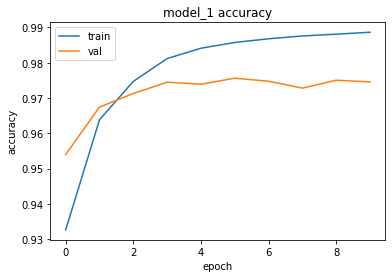

In [49]:
plt.plot(model_1.history.history['accuracy'])
plt.plot(model_1.history.history['val_accuracy'])
plt.title('model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 
embeddings = tf.keras.layers.Embedding(len(word2id),
                                       300,
                                       weights=[weight_matrix],
                                       input_length=MAX_LEN,
                                       trainable=False)(inputs)

gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(N_LEN, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(N_LEN, return_sequences=True))(gru_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_2)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])


In [51]:
model_2.fit(X, y, 
            validation_data=(X_test, y_test),
            batch_size=256,
            epochs=10)

Epoch 1/10
79/79 [==============================] - 13s 60ms/step - loss: 0.2827 - accuracy: 0.9168 - val_loss: 0.1564 - val_accuracy: 0.9522
Epoch 2/10
79/79 [==============================] - 2s 24ms/step - loss: 0.1335 - accuracy: 0.9556 - val_loss: 0.1177 - val_accuracy: 0.9614
Epoch 3/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0983 - accuracy: 0.9670 - val_loss: 0.0952 - val_accuracy: 0.9687
Epoch 4/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0766 - accuracy: 0.9744 - val_loss: 0.0906 - val_accuracy: 0.9699
Epoch 5/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0620 - accuracy: 0.9795 - val_loss: 0.0957 - val_accuracy: 0.9701
Epoch 6/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0525 - accuracy: 0.9831 - val_loss: 0.0998 - val_accuracy: 0.9708
Epoch 7/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0468 - accuracy: 0.9850 - val_loss: 0.0983 - val_accuracy: 0.9717
Epoch 8/10
7

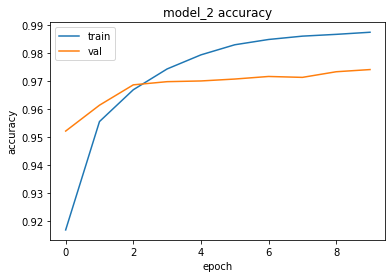

In [52]:
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])
plt.title('model_2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

### Модель BILSTM:

In [61]:
from sklearn.metrics import classification_report

pred = model_1.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1),
                            pred.reshape(-1),
                            labels=list(id2labels.keys()),
      target_names=list(id2labels.values()),
      zero_division=0))

              precision    recall  f1-score   support

           O       0.83      0.97      0.89     40480
       B-PER       0.90      0.38      0.53      3542
       I-PER       0.97      0.63      0.76      7544
       B-ORG       0.51      0.59      0.55      4074
       I-ORG       0.74      0.71      0.72      8008
       B-LOC       0.85      0.51      0.64      4560
       I-LOC       0.89      0.58      0.70      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.83      0.67      0.72    540000
weighted avg       0.98      0.97      0.97    540000



Можем заметить, что по значениям метрик отличий в целом практически нет.

In [57]:
text = """Сегодня Аня Щербакова и Вася Пупкин поели в МакДональдсе на проспекте Независимости в Минске, что для жителей Москвы и, возможно, России в целом, может показаться роскошью."""

In [58]:
text

'Сегодня Аня Щербакова и Вася Пупкин поели в МакДональдсе на проспекте Независимости в Минске, что для жителей Москвы и, возможно, России в целом, может показаться роскошью.'

In [59]:
label_seq(text, word2id, id2labels, MAX_LEN, model_1)

[('Сегодня', 'O'),
 ('Аня', 'I-ORG'),
 ('Щербакова', 'O'),
 ('и', 'O'),
 ('Вася', 'B-LOC'),
 ('Пупкин', 'O'),
 ('поели', 'O'),
 ('в', 'O'),
 ('МакДональдсе', 'O'),
 ('на', 'O'),
 ('проспекте', 'O'),
 ('Независимости', 'I-ORG'),
 ('в', 'O'),
 ('Минске', 'B-LOC'),
 (',', 'O'),
 ('что', 'O'),
 ('для', 'O'),
 ('жителей', 'O'),
 ('Москвы', 'B-LOC'),
 ('и', 'O'),
 (',', 'O'),
 ('возможно', 'O'),
 (',', 'O'),
 ('России', 'B-ORG'),
 ('в', 'O'),
 ('целом', 'O'),
 (',', 'O'),
 ('может', 'O'),
 ('показаться', 'O'),
 ('роскошью', 'O'),
 ('.', 'O')]

### Модель BIGRU:

In [62]:
pred = model_2.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1),
                            pred.reshape(-1),
                            labels=list(id2labels.keys()),
      target_names=list(id2labels.values()),
      zero_division=0))

              precision    recall  f1-score   support

           O       0.80      0.98      0.88     40480
       B-PER       0.90      0.33      0.48      3542
       I-PER       0.96      0.66      0.79      7544
       B-ORG       0.57      0.54      0.55      4074
       I-ORG       0.80      0.67      0.73      8008
       B-LOC       0.81      0.49      0.61      4560
       I-LOC       0.86      0.58      0.69      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.84      0.66      0.72    540000
weighted avg       0.98      0.97      0.97    540000



In [60]:
label_seq(text, word2id, id2labels, MAX_LEN, model_2)

[('Сегодня', 'O'),
 ('Аня', 'I-ORG'),
 ('Щербакова', 'O'),
 ('и', 'O'),
 ('Вася', 'O'),
 ('Пупкин', 'O'),
 ('поели', 'O'),
 ('в', 'O'),
 ('МакДональдсе', 'O'),
 ('на', 'O'),
 ('проспекте', 'O'),
 ('Независимости', 'O'),
 ('в', 'O'),
 ('Минске', 'B-LOC'),
 (',', 'O'),
 ('что', 'O'),
 ('для', 'O'),
 ('жителей', 'O'),
 ('Москвы', 'B-LOC'),
 ('и', 'O'),
 (',', 'O'),
 ('возможно', 'O'),
 (',', 'O'),
 ('России', 'B-LOC'),
 ('в', 'O'),
 ('целом', 'O'),
 (',', 'O'),
 ('может', 'O'),
 ('показаться', 'O'),
 ('роскошью', 'O'),
 ('.', 'O')]

Модель BILSTM выделяет больше сущностей, асложно сказать, какая из моделей более точно выделяет тип сущности (и там, и там плоховато).